In [ ]:
##################################################
# THIS CELL APPLIES ONLY IF YOU RUN THE NOTEBOOK
#             WITHIN GOOGLE COLAB
# PLEASE press "Copy to Google Drive" button on Colab button bar
##################################################
# You need to perform these steps only 
# the first time you connect to COLAB
###################################
# except the "cd %APET" MUST BE RUN every time!
###################################
# REMOVE THE # FROM each of the following commands
# and run the whole first cell (CTRL + ENTER)
##################################################

# Clone the repo.
#!git clone https://github.com/mcogoni/APET.git

# Change the working directory to the repo root.
%cd APET

# Add the repo root to the Python path.
#import sys, os
#sys.path.append(os.getcwd())

# Install suntime for astro info
#!pip3 install suntime

In [1]:
from spot_processing import Station
from collections import defaultdict
import urllib.request
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime, time
from coords_utils import *
import random
import matplotlib.dates as mdates


def polar2cart(r, theta, phi):
    r = math.fabs(r)
    theta = pi/2.-theta/360.*2*pi
    phi = phi/360.*2*pi
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]


def read_pattern_data(filename):
    with open(filename, "r") as fd:
        data = fd.readlines()

    header = data[0].strip().split(",")
    pattern_list = []
    for row in data[1:]:
        els = [float(el) for el in row.strip().split(",")]
        pattern_list.append(els)

    return header, pattern_list

def strip_data(data):
    for i, row in enumerate(data):
        for j, el in enumerate(row):
            data[i][j] = el.strip()
    return data


def running_mean(x, N):
    x = np.array(x)
    x = np.concatenate((x, x[0:N-1]), axis=0)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def get_url(band, spot_number, reporter):
    return "http://wsprnet.org/olddb?mode=html&band=%d&limit=%d&findcall=&findreporter=%s&sort=date" % (band, spot_number, reporter)


def download_wspr_data(band, spot_number, reporter):
    link = get_url(band, spot_number, reporter)
    contents = urllib.request.urlopen(link).read()
    
    return contents


def extract_wspr_data(contents, timestamp_start, timestamp_stop):
    d_dict = defaultdict(list)
    reporter_loc_dict = {}

    for content in contents:
        for row in content.splitlines():
            row = row.decode()
            if "<tr id=\"evenrow\"><td align=left>&nbsp;" in row or "<tr id=\"oddrow\"><td align=left>&nbsp;" in row:
                row = row.replace("&nbsp", "")
                row_list = row.split(";")[1::2]
                #print (row_list)
                timestamp = row_list[0]
                callsign = row_list[1]
                frequency = float(row_list[2])
                snr = float(row_list[3])
                locator = row_list[5]
                power = float(row_list[7])
                reporter = row_list[8]
                reporter_locator = row_list[9]
                distance = float(row_list[10])
                
                if timestamp_stop >= get_unixtime(timestamp) >= timestamp_start:
                    d_dict[reporter].append((timestamp, callsign, frequency, snr, locator, power, distance))
                    reporter_loc_dict[reporter] = (reporter_locator)
                else:
                    #d_dict[reporter].append(None)
                    reporter_loc_dict[reporter] = (reporter_locator)
                
    return reporter_loc_dict, d_dict

def extract_info(d_dict):
    callsign_dict = defaultdict(int)
    coord_dict = {}
    dist_dict = {}
    for reporter in d_dict:
        dist_dict = {el[1]: el[6] for el in d_dict[reporter]}
        for el in d_dict[reporter]:
            call = el[1]
            locator = el[4]
            callsign_dict[call] += 1
            
            coord_dict[call] = loc2coords(locator)
                
    return dist_dict, coord_dict, callsign_dict


def most_spotted(callsign_dict):
    callsign_sorted_byspots = sorted(callsign_dict, key=callsign_dict.get, reverse=True)
    return callsign_sorted_byspots


def data_by_callsign(callsign_sorted_byspots, d_dict):
    data_bycallsign_dict = {}
    for call in callsign_sorted_byspots:
        data_bycallsign_dict[call] = {}
        for reporter in d_dict:
            tmp_dict = []
            for el in d_dict[reporter]:
                if call in el:
                    tmp_dict.append(el[0:1]+el[2:])
            data_bycallsign_dict[call][reporter] = tmp_dict
    return data_bycallsign_dict


def data_by_callsign_common(data_bycallsign_dict, reporter_list):
    common_ts_bycall = {}
    for call in data_bycallsign_dict.keys():
        if sum([1 for rep in data_bycallsign_dict[call]]) == 2: # check whether callsign was heard by both reporters
            timeseries_list = []
            for rep in reporter_list:
                ts_tmp = [el[0] for el in data_bycallsign_dict[call][rep]]
                #ts_tmp = sorted(ts_tmp, key=lambda k: get_unixtime(k), reverse=False)
                timeseries_list.append(ts_tmp)
            common_ts = []
            for i, ts1 in enumerate(timeseries_list[0]):
                if ts1 in timeseries_list[1]:
                    j = timeseries_list[1].index(ts1)
                    common_ts.append((i,j))
            common_ts_bycall[call] = common_ts

    return common_ts_bycall


def get_unixtime(date_string):
    date_time_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M')
    unixtime = time.mktime(date_time_obj.timetuple())
    return unixtime


def plot_avg_snr(data_bycallsign_dict, timestamp_start, timestamp_stop, reporter_list):
    ax = plt.figure(figsize=(20,10))
    
    for i, reporter in enumerate(reporter_list):
        snr_list_ = []
        for call in data_bycallsign_dict:
            timeseries = data_bycallsign_dict[call][reporter]
            timeseries = sorted(timeseries, key=lambda k: timeseries[0], reverse=True)
            unixtime_list = [get_unixtime(el[0]) for el in timeseries]
            
            snr_list = [el[2] for el in timeseries]
            datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
            snr_list_.append( (unixtime_list, snr_list) )
        
        avg_snr_dict = defaultdict(list)
        for data in snr_list_:
            ts_list = data[0]
            snr_list__ = data[1]
            for ts, snr in zip(ts_list, snr_list__):
                avg_snr_dict[ts].append(snr)
        x_list = []
        y_list = []
        for ts in avg_snr_dict:
            x_list.append(ts)
            y_list.append(np.mean(avg_snr_dict[ts]))

            #plt.errorbar(datetime.datetime.fromtimestamp(ts), np.mean(avg_snr_dict[ts]),yerr=np.std(avg_snr_dict[ts]), c=["r", "k"][i])
            plt.scatter(datetime.datetime.fromtimestamp(ts), np.mean(avg_snr_dict[ts]), c=["r", "k"][i])

        (m, b) = np.polyfit(x_list, y_list, 1)
        yp = np.polyval([m, b], x_list)
        plt.plot([datetime.datetime.fromtimestamp(x) for x in x_list], yp, c=["r", "k"][i], 
            label="Linear fit of SNR trend for %s: %f dB/h"%(reporter, m*3600))
        #plt.plot([datetime.datetime.fromtimestamp(x) for x in x_list], running_mean(y_list, 10), c=["r", "k"][i], 
        #    label="SNR running AVG for %s"%(reporter), linestyle='dashed')

    plt.grid()
    plt.title("Time evolution of SNR for two antennas (AVG)")
    plt.xlabel("Time")
    plt.ylabel("SNR (dB)")
    plt.xlim(datetime.datetime.fromtimestamp(timestamp_start), datetime.datetime.fromtimestamp(timestamp_stop))
    plt.legend()




def get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, 
  timestamp_start, timestamp_stop, antenna_rotation_time, topn=-1, plot_flag=False):
    if plot_flag:
        ax = plt.figure(figsize=(30,20))
    snr_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        snr_dict[call] = {}
        for i, reporter in enumerate(data_bycallsign_dict[call]):
            timeseries = data_bycallsign_dict[call][reporter]
            timeseries = sorted(timeseries, key=lambda k: timeseries[0], reverse=True)
            unixtime_list = [get_unixtime(el[0]) for el in timeseries]
            snr_list = [el[2] for el in timeseries]
            datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
            snr_dict[call][reporter] = (unixtime_list, snr_list)
            if plot_flag:
                plt.plot(datetime_list, snr_list, "-o", label=call+" "+reporter, alpha=0.6, c=["r", "k"][i])
                #text(unixtime_list[0], snr_list[0], "%s"%call)

    #legend()
    if plot_flag:
        #plt.axvline(timestamp_start, c="r")
        #plt.axvline(antenna_rotation_time, c="b")
        plt.grid()
        plt.title("Time evolution of SNR for two antennas")
        plt.xlabel("Time")
        plt.ylabel("SNR (dB)")
        plt.xlim(datetime.datetime.fromtimestamp(timestamp_start), datetime.datetime.fromtimestamp(timestamp_stop))

    return snr_dict


def get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict,
  timestamp_start, timestamp_stop, antenna_rotation_time, reporter_list, common_ts_bycall, rx_offset, topn=-1, plot_flag=False, country=False):
    if plot_flag:
        ax = plt.figure(figsize=(26,20))
        N = 12000
        cmap = plt.get_cmap('gist_ncar',N)

    deltasnr_bycall_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        timeseries = common_ts_bycall[call]
        if len(timeseries) == 0:
            continue
        unixtime_list = [get_unixtime(data_bycallsign_dict[call][reporter_list[0]][el[0]][0]) for el in timeseries]
        snr_list_0 = [data_bycallsign_dict[call][reporter_list[0]][el[0]][2] for el in timeseries]
        snr_list_1 = [data_bycallsign_dict[call][reporter_list[1]][el[1]][2] for el in timeseries]

        unixtime_list, snr_list_0, snr_list_1 = (list(t) for t in zip(*sorted(zip(unixtime_list, snr_list_0, snr_list_1), key=lambda k: k[0], reverse=False)))
        datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
        deltasnr_list = [snr_1-snr_0-rx_offset for snr_0,snr_1 in zip(snr_list_0, snr_list_1)]

        deltasnr_bycall_dict[call] = (unixtime_list, deltasnr_list)
        if plot_flag:
            cdist = data_bycallsign_dict[call][reporter_list[0]][0][-1]
            
            sc = plt.plot(datetime_list, deltasnr_list, "-o", label=call+" "+reporter_list[0], color=cmap(int(cdist)))
            if not country:
                plt.text(datetime_list[0], deltasnr_list[0]+0.5*random.random(), "%s"%call)
                if len(unixtime_list)>1:
                    plt.text(datetime_list[-1], deltasnr_list[-1]+0.5*random.random(), "%s"%call)
            else:
                plt.text(datetime_list[0], deltasnr_list[0]+0.5*random.random(), Station(call).country)

    if plot_flag:
        #plt.axvline(timestamp_start, c="r")
        #plt.axvline(antenna_rotation_time, c="b")
        plt.grid()
        plt.title("Time evolution of difference in SNR between two antennas")
        plt.xlabel("Time")
        plt.ylabel("Delta SNR (dB)")
        plt.xlim(datetime.datetime.fromtimestamp(timestamp_start), datetime.datetime.fromtimestamp(timestamp_stop))
        plt.ylim(-25, 25)
        norm = mpl.colors.Normalize(vmin=0,vmax=12000)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Distance (km)')
        #plt.gcf().fmt_xdata = mdates.DateFormatter('%H-%M')
        #plt.gcf().autofmt_xdate()
        #legend()
    return deltasnr_bycall_dict

def plot_angle_bycall(callsign_sorted_byspots, data_bycallsign_dict,
  timestamp_start, timestamp_stop, antenna_rotation_time, reporter_list, common_ts_bycall, rx_offset, topn=-1, plot_flag=False, country=False):
    if plot_flag:
        ax = plt.figure(figsize=(26,20))
        N = 12000
        cmap = plt.get_cmap('gist_ncar',N)

    deltasnr_bycall_dict = {}
    for call in callsign_sorted_byspots[:topn]:
        timeseries = common_ts_bycall[call]
        if len(timeseries) == 0:
            continue
        unixtime_list = [get_unixtime(data_bycallsign_dict[call][reporter_list[0]][el[0]][0]) for el in timeseries]
        snr_list_0 = [data_bycallsign_dict[call][reporter_list[0]][el[0]][2] for el in timeseries]
        snr_list_1 = [data_bycallsign_dict[call][reporter_list[1]][el[1]][2] for el in timeseries]

        unixtime_list, snr_list_0, snr_list_1 = (list(t) for t in zip(*sorted(zip(unixtime_list, snr_list_0, snr_list_1), key=lambda k: k[0], reverse=False)))
        datetime_list = [datetime.datetime.fromtimestamp(ts) for ts in unixtime_list]
        deltasnr_list = [snr_1-snr_0-rx_offset for snr_0,snr_1 in zip(snr_list_0, snr_list_1)]

        deltasnr_bycall_dict[call] = (unixtime_list, deltasnr_list)
        if plot_flag:
            cdist = data_bycallsign_dict[call][reporter_list[0]][0][-1]
            
            sc = plt.plot(datetime_list, deltasnr_list, "-o", label=call+" "+reporter_list[0], color=cmap(int(cdist)))
            if not country:
                plt.text(datetime_list[0], deltasnr_list[0]+0.5*random.random(), "%s"%call)
                if len(unixtime_list)>1:
                    plt.text(datetime_list[-1], deltasnr_list[-1]+0.5*random.random(), "%s"%call)
            else:
                plt.text(datetime_list[0], deltasnr_list[0]+0.5*random.random(), Station(call).country)

    if plot_flag:
        #plt.axvline(timestamp_start, c="r")
        #plt.axvline(antenna_rotation_time, c="b")
        plt.grid()
        plt.title("Time evolution of difference in SNR between two antennas")
        plt.xlabel("Time")
        plt.ylabel("Delta SNR (dB)")
        plt.xlim(datetime.datetime.fromtimestamp(timestamp_start), datetime.datetime.fromtimestamp(timestamp_stop))
        plt.ylim(-25, 25)
        norm = mpl.colors.Normalize(vmin=0,vmax=12000)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Distance (km)')
        #plt.gcf().fmt_xdata = mdates.DateFormatter('%H-%M')
        #plt.gcf().autofmt_xdate()
        #legend()
    return deltasnr_bycall_dict


In [2]:
%pylab inline

from spot_processing import Station
from collections import defaultdict
import urllib.request
import numpy as np
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime, time
from coords_utils import *
#from wspr_utils import *
from suntime import Sun, SunTimeException

# Ionosonde data (Roma)
# http://ionos.ingv.it/Roma/hourly_data/

# Pushkov Institute of Terrestrial Magnetism, Ionosphere and Radio Wave Propagation
# Russian Academy of Sciences 
# http://www.izmiran.ru/services/iweather/grif/Maps/hmF2/2019/

################################################
# IMPORTANT IN ORDER TO HAVE MEANINGFUL RESULTS!
rx_offset = 3   # rx sensitivity difference (db) 
                # between two receivers (should
                # be done by connecting both rx
                # to the same antenna)
###############################################

band = 20 # 20 meters band or whatever
spot_number = 5000 # how many spots to download matching the following callsign criteria
reporter_list =  ["IS0KYB2", "IS0KYB1"] # The first is the reference antenna (omnidirectional if possible: small magnetic loop or vertical dipole)
reporter_loc = "JM49jn" # Locator of RX antennas

rep_lat, rep_lon = loc2coords(reporter_loc) # get QTH coords

sun = Sun(rep_lat, rep_lon) # create the Sun object to gather astro data

# Get today's sunrise and sunset in UTC
today_sr = sun.get_sunrise_time()
today_ss = sun.get_sunset_time()
print ("*"*50)
print ("Today Sunrise: %s" % today_sr)
print ("Today Sunset: %s" % today_ss)
print ("*"*50)

timestamp_start = get_unixtime("2019-04-12 08:00") # Filter spots earlier than this (UTC!)
timestamp_stop = get_unixtime("2019-04-12 22:30") # Filter any spot later than this

antenna_rotation_time = get_unixtime("2019-04-10 15:40") # ignore this, experimental feature
#angle_offset = -90.

# download and parse data from WSPR db
contents = []
for reporter in reporter_list:
    tmp = download_wspr_data(band, spot_number, reporter)
    contents.append(tmp)
reporter_loc_dict, d_dict= extract_wspr_data(contents, timestamp_start, timestamp_stop)
dist_dict, coord_dict, callsign_dict = extract_info(d_dict)

Populating the interactive namespace from numpy and matplotlib
**************************************************
Today Sunrise: 2019-04-13 04:52:00+00:00
Today Sunset: 2019-04-13 18:00:00+00:00
**************************************************


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['radians', 'sin', 'degrees', 'sqrt', 'pi', 'cos', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# get the most spotted stations and their occurrences

callsign_sorted_byspots = most_spotted(callsign_dict)
data_bycallsign_dict = data_by_callsign(callsign_sorted_byspots, d_dict)

In [4]:
# create a dictionary of sorted SNR timeseries with [call] and [reporter] as keys

snr_dict = get_snr_bycall(callsign_sorted_byspots, data_bycallsign_dict, timestamp_start, timestamp_stop, antenna_rotation_time, topn=-1, plot_flag=False)

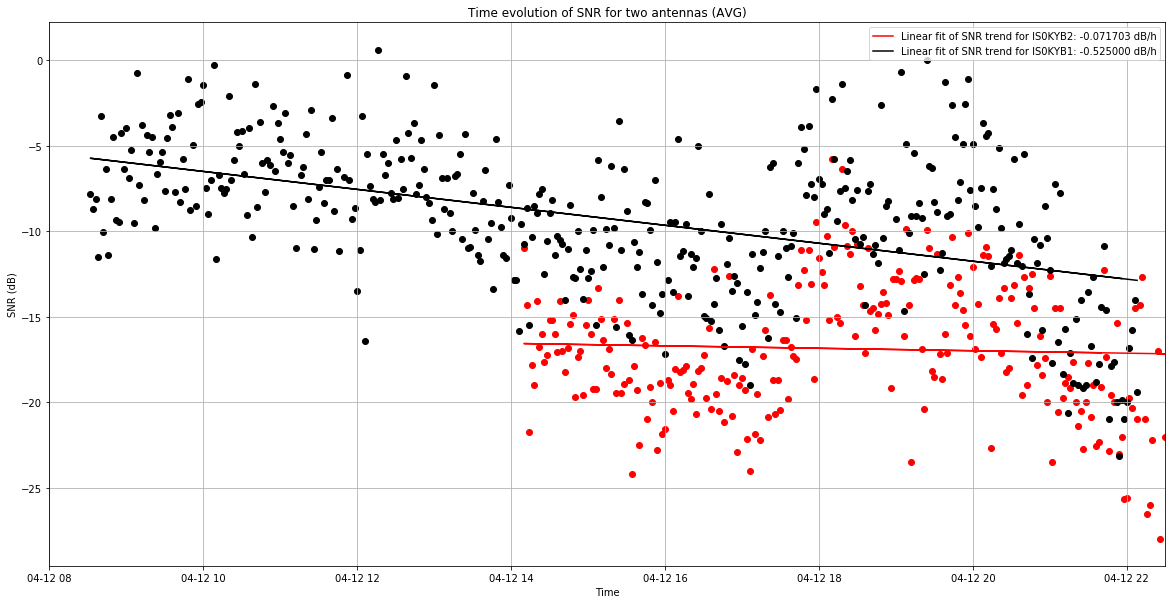

In [5]:
# SNR trend for both receivers and their linear fit with a dB/h rough estimation

plot_avg_snr(data_bycallsign_dict, timestamp_start, timestamp_stop, reporter_list)

In [6]:
# compute the common parts (wrt reporters) of timeseries (return timestamps for both reporters)

common_ts_bycall = data_by_callsign_common(data_bycallsign_dict, reporter_list)

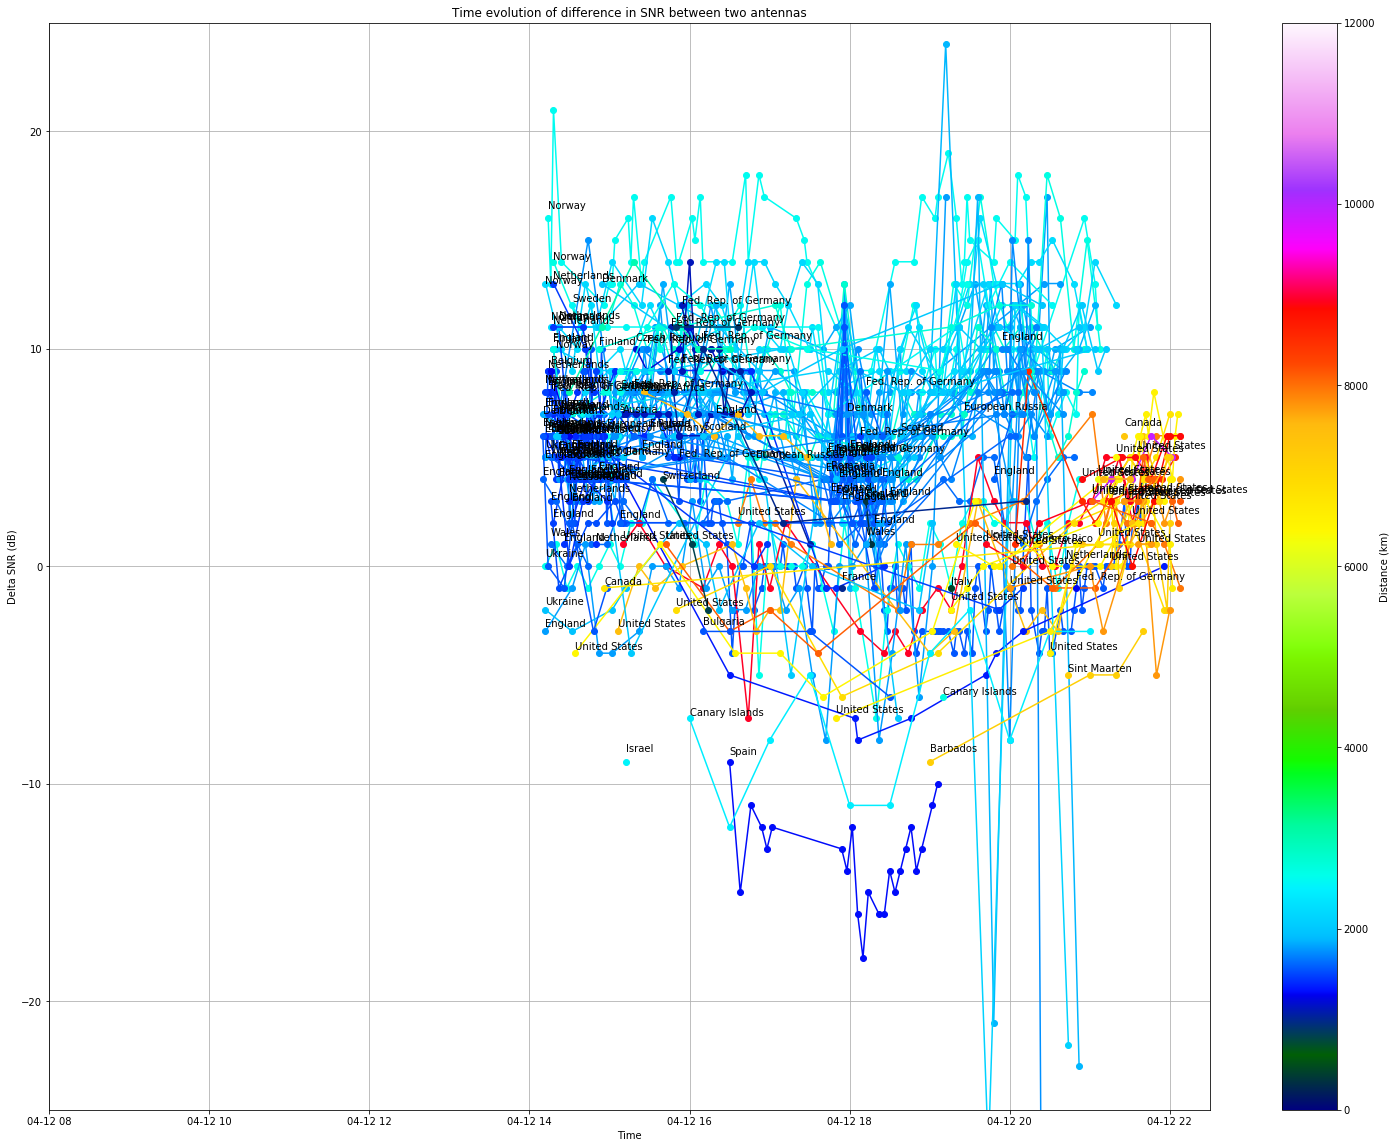

In [7]:
# create a dictionary of sorted DELTA SNR timeseries with [call] as key

deltasnr_dict = get_deltasnr_bycall(callsign_sorted_byspots, data_bycallsign_dict, timestamp_start, timestamp_stop, antenna_rotation_time, reporter_list, common_ts_bycall, rx_offset, topn=-1, plot_flag=True, country=True)

(-10, 370)

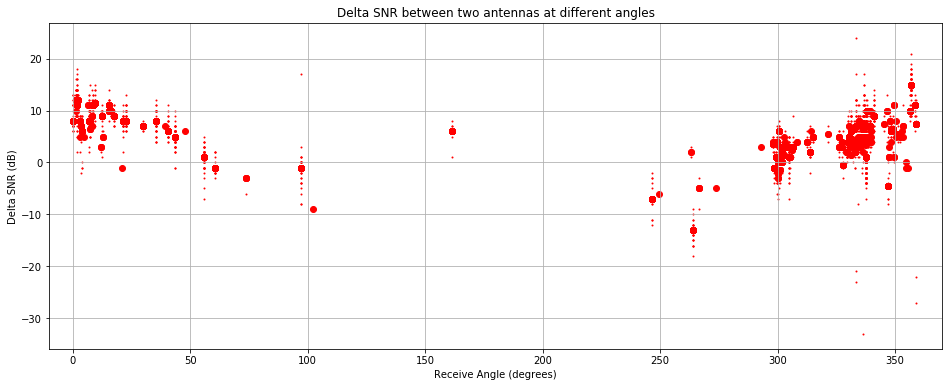

In [8]:
# Scatter plot of the difference in dB between the two antennas

plt.figure(figsize=(16,6))
for call in deltasnr_dict:
    deltasnr_list = deltasnr_dict[call]
    
    az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] for el in deltasnr_list[0]]
    deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0])]
    
    #az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] for el in deltasnr_list[0] if el >= antenna_rotation_time]
    #az_list2 = [(haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] + angle_offset) for el in deltasnr_list[0] if el < antenna_rotation_time]
    #deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el >= antenna_rotation_time]
    #deltasnr_list2 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el < antenna_rotation_time]
    
    plt.scatter(az_list1, deltasnr_list1, s=1, c="r")
    plt.scatter(az_list1, [np.median(deltasnr_list1) for _ in az_list1], c="r") #, yerr=[0.0*np.var(deltasnr_list1)  for _ in az_list1], fmt='o')
    #plt.scatter(az_list2, deltasnr_list2, s=1, c="b")
    #plt.scatter(az_list2, [np.median(deltasnr_list2) for _ in az_list2], c="b") #, yerr=[0.0*np.var(deltasnr_list2)  for _ in az_list2], fmt='o')
plt.grid()
plt.title("Delta SNR between two antennas at different angles")
plt.xlabel("Receive Angle (degrees)")
plt.ylabel("Delta SNR (dB)")
plt.xlim(-10,370)

/usr/lib/python3/dist-packages/matplotlib/projections/polar.py:162: RuntimeWarning: invalid value encountered in less
  theta = np.where(y < 0, 2 * np.pi - theta, theta)


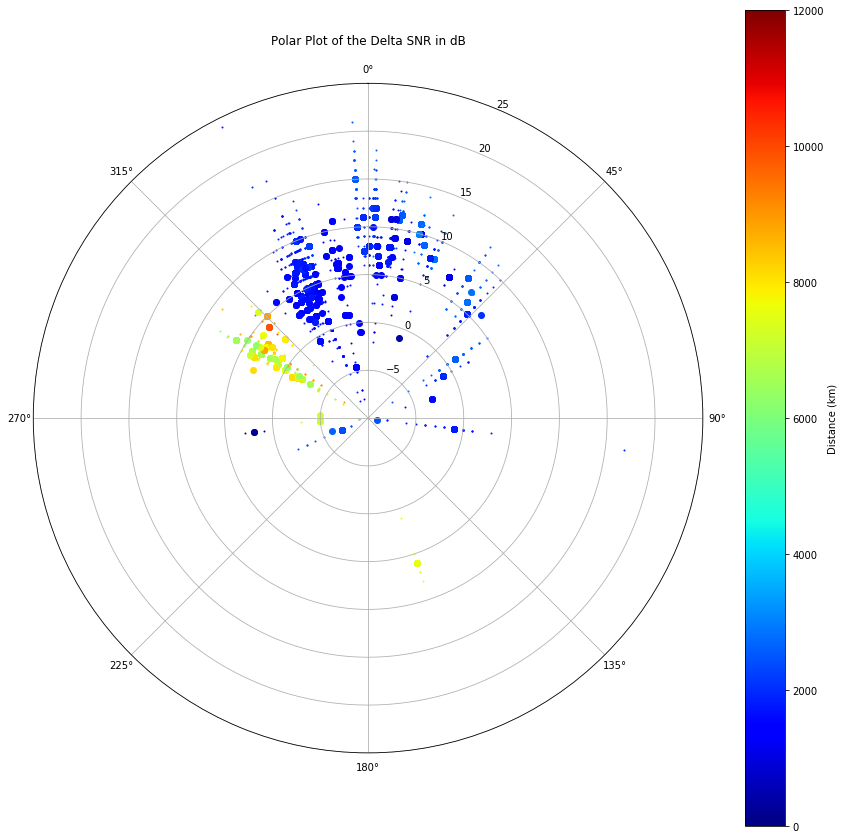

In [76]:
# Polar scatter plot of the difference in dB between the two antennas

max_dist = 12000
cmap = plt.get_cmap('jet',max_dist)

az_complete_list = []
deltasnr_complete_list = []
deltasnr_median_list = []
distance_list = []

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
for call in deltasnr_dict:
    cdist = data_bycallsign_dict[call][reporter_list[0]][0][-1]
    distance_list.append([int(cdist) for _ in deltasnr_dict[call]])
    deltasnr_list = deltasnr_dict[call]
    
    az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1]/360.*2*pi for el in deltasnr_list[0]]
    deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0])]
    
    #az_list1 = [haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1]/360.*2*pi for el in deltasnr_list[0] if el >= antenna_rotation_time]
    #az_list2 = [(haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1] + angle_offset)/360.*2*pi for el in deltasnr_list[0] if el < antenna_rotation_time]
    #deltasnr_list1 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el >= antenna_rotation_time]
    #deltasnr_list2 = [deltasnr_list[1][i] for i, el in enumerate(deltasnr_list[0]) if el < antenna_rotation_time]
    
    if len(az_list1):
        for az, deltasnr in zip(az_list1, deltasnr_list1):
            az_complete_list.append(az)
            deltasnr_complete_list.append(deltasnr)
    #if len(az_list2):
    #    for az, deltasnr in zip(az_list2, deltasnr_list2):
    #        az_complete_list.append(az)
    #        deltasnr_complete_list.append(deltasnr)
    
    angle = haversine(*loc2coords(reporter_loc), *coord_dict[call] )[1]/360.*2*pi
    delta_snr = np.median(deltasnr_list1)
    deltasnr_median_list.append((angle, delta_snr))
    plt.scatter(az_list1, deltasnr_list1, s=1, color=cmap(int(cdist)))
    plt.scatter(az_list1, [np.median(deltasnr_list1) for _ in az_list1], color=cmap(int(cdist))) #, yerr=[0.0*np.var(deltasnr_list1)  for _ in az_list1], fmt='o')
    #plt.scatter(az_list2, deltasnr_list2, s=1, c="b")
    #plt.scatter(az_list2, [np.median(deltasnr_list2) for _ in az_list2], c="b") #, yerr=[0.0*np.var(deltasnr_list2)  for _ in az_list2], fmt='o')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,25)
plt.title("Polar Plot of the Delta SNR in dB")

norm = mpl.colors.Normalize(vmin=0,vmax=max_dist)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Distance (km)')

#az_complete_list = [a for a in el for el in az_complete_list]
#deltasnr_complete_list = [a for a in el for el in deltasnr_complete_list]

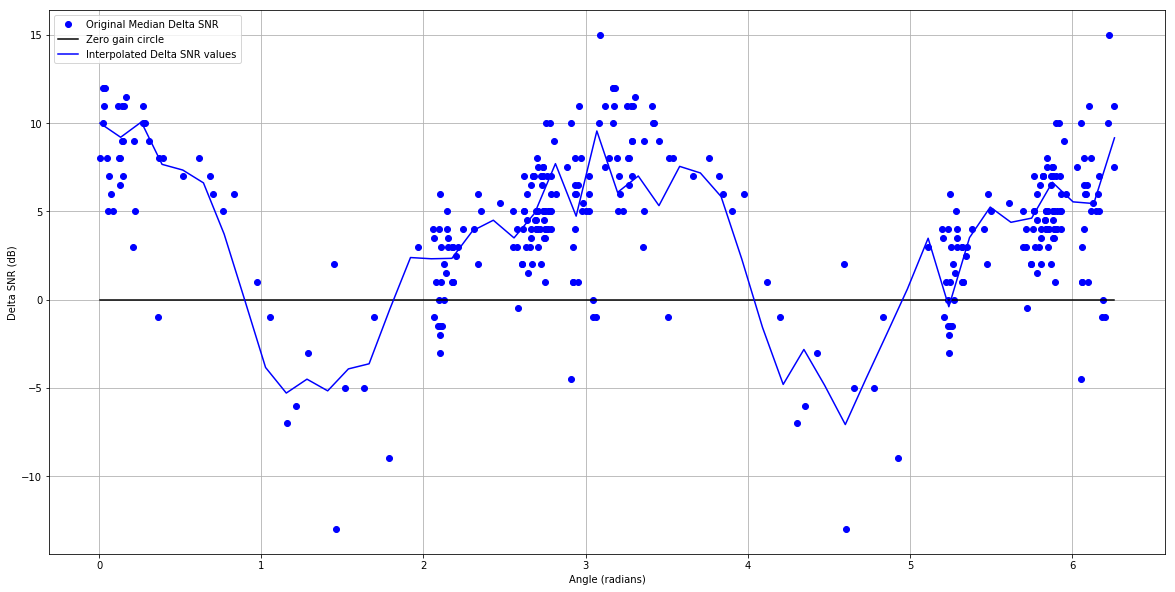

In [65]:
# Here we convert degrees to radians and perform a VERY rough 1D LINEAR interpolation 
# Higher order interpolations easily explode, should find a better way, maybe by pruning
# the snr array

use_symmetry = True
az_rad_list = []
deltasnr_list = []
for i,v in enumerate(deltasnr_median_list):
    az_rad_list.append( v[0] + 0.0001*(2*rand()-1.) )
    deltasnr_list.append(v[1])
    if use_symmetry:
        az_rad_list.append((v[0]+pi) %(2*pi))
        deltasnr_list.append(v[1])
        distance_list.append(distance_list[i])
    
angles, gains = zip(*sorted(zip(az_rad_list, deltasnr_list)))

x = np.array(angles)
y = np.array(gains)
y_rm = running_mean(y,3) # try to smoothen the points before interpolating

x0 = np.linspace(np.min(x),np.max(x))
y0 = np.zeros(x0.shape)

f = interpolate.interp1d(x, y_rm, kind="linear")
figure(figsize=(20,10))
plot(x, y, 'bo', label = 'Original Median Delta SNR')
plot(x0, y0, 'k', label = 'Zero gain circle')
plot(x0, f(x0), 'b', label = 'Interpolated Delta SNR values')
grid()
xlabel("Angle (radians)")
ylabel("Delta SNR (dB)")
#xlim(0,6.28)
#ylim(-30,30)
legend()

(-10, 30)

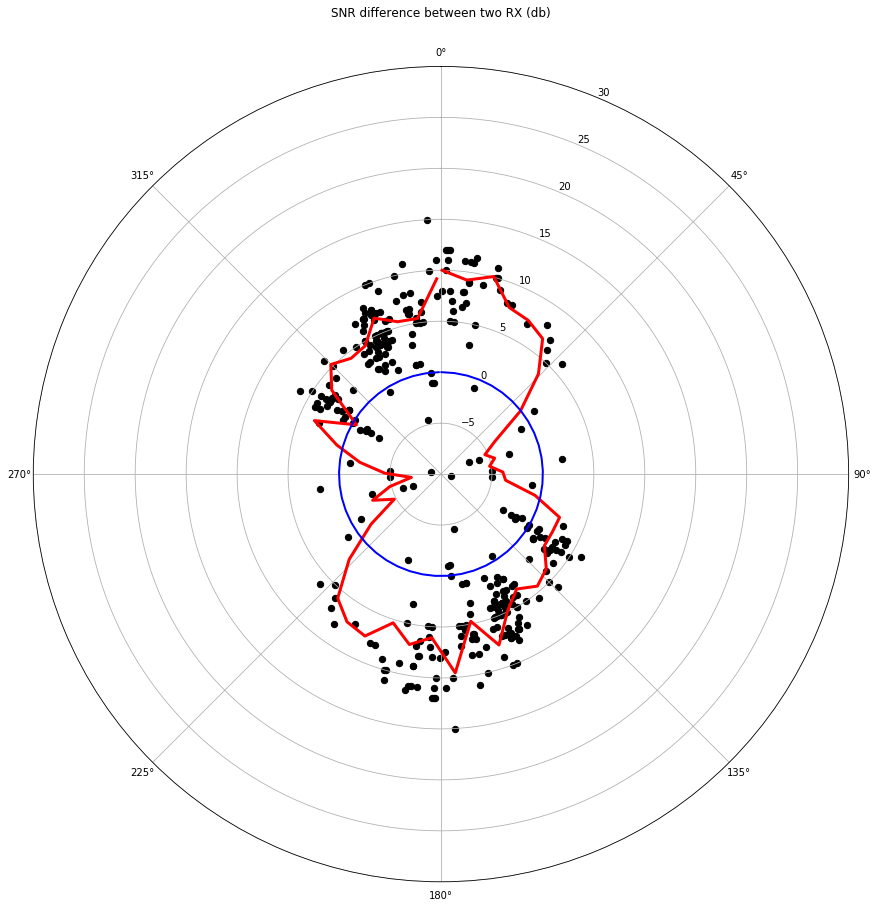

In [66]:
# Now let's finally plot the polar graph with the real SNR deltas and their interpolation
# Moreover, we plot the angular distance distribution of the spots

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
c = ax.plot(x0, f(x0), c='r', linewidth=3)
c0 = ax.plot(x0, y0, c='b', linewidth=2)
c2 = ax.scatter(x, y, c='k', s=40)

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,30)

#fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(111, projection='polar')
#ax.set_title("Distance distribution of the received stations (km)", va='bottom')


#c2 = ax.scatter(x, dist_list, c='k', s=80)

#ax.set_theta_zero_location('N', offset=0)
#ax.set_theta_direction(-1)


In [67]:
# Load CSV gain patterns produced with MMANA

fn_list = ["LazyH-16m.csv", "4cross_quads.csv"]

pattern_list_list = []
for fn in fn_list:
    header, pattern_list = read_pattern_data(fn)
    pattern_list_list.append(pattern_list)

In [68]:
# Save to CSV the difference pattern and create a data structure for it

fn_out = "diff_pattern.csv"

diff_pattern = []
a_pattern = []
b_pattern = []

with open(fn_out, "w") as fd:
    fd.write(",".join(header)+"\n")
    diff_pattern_list = []
    for row1, row2 in zip(*pattern_list_list):
        #print(row1, row2, row1[2]-row2[2], row1[3]-row2[3], row1[4]-row2[4])
        diff = "%3.1f,%3.1f,%3.2f,%3.2f,%3.2f\n"%(row1[0], row1[1], row1[2]-row2[2], row1[3]-row2[3], row1[4]-row2[4])
        fd.write(diff)
        diff_pattern.append([row1[0], row1[1], row1[4]-row2[4]])
        a_pattern.append([row1[0], row1[1], row1[4]])
        b_pattern.append([row2[0], row2[1], row2[4]])
        

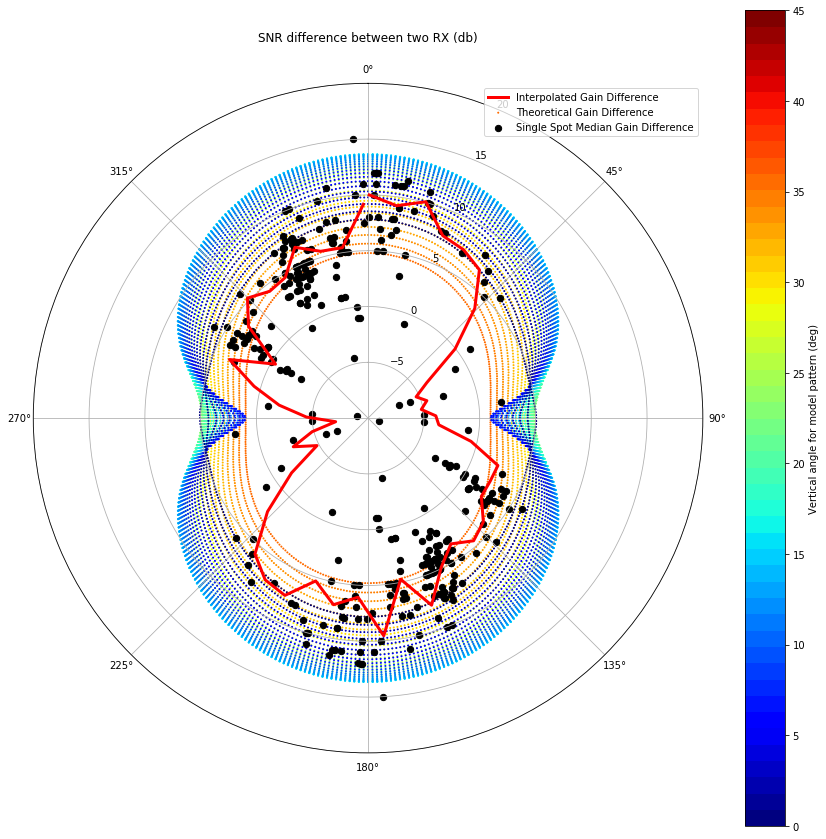

In [73]:
# Plot the Theoretical Gain Difference along with the interpolation and real data
# The model gain is plotted at several vertical angles 

N_angles = 50
N_km = 12000
cmap = plt.get_cmap('jet', N_angles)
cmap2 = plt.get_cmap('jet', N_km)

zen_min, zen_max = 0., 45 # select Zenith angle range for the theoretical pattern

az_list = []
zen_list = []
gain_list = []
for row in diff_pattern:
    zen = 90-row[0]
    az = row[1]
    
    gain = row[2]
    if zen_min <= zen <= zen_max:
        az_list.append(az/360.*2*pi)
        zen_list.append(zen/360.*2*pi)
        
        gain_list.append(gain)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='polar')
c2 = ax.scatter(az_list, gain_list, color=cmap(zen_list), s=1, label="Theoretical Gain Difference")

c = ax.plot(x0, f(x0), c='r', linewidth=3, label="Interpolated Gain Difference")
c1 = ax.scatter(x, y, c="k", s=40, label="Single Spot Median Gain Difference")

ax.set_title("SNR difference between two RX (db)", va='bottom')

ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)
ax.set_rlim(-10,20)
ax.legend()

norm = mpl.colors.Normalize(vmin=0,vmax=45)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Vertical angle for model pattern (deg)')
